# Mandelbrot Set with PYNQ

## Summary

in this notebook a mandelbrot plot has been implemented in unison with a PYNQ chip. This project began with 2 models being created in system generator 2020.2, one for the squaring of the Z term in the mandelbrot equation and one for the magnitude approximation. An Intellectual Property core for each model was created to perform these tasks. This was then implemented into vivado before using the bitstream and hardware hand-off files with this notebook to compute and plot the mandelbrot set.

The mandelbrot set equation is: $ z_{n+1} = z_{n}^{2} + c$

Figure 1 is the Mandelbrot Squaring .slx file and Figure 2 is the Magnitude Approximation .slx file An IP was generated for both .slx files and a block diagram was created including both IPs and the PYNQ chip IP, this is Figure 3.

# Software

Below is a version of the mandelbrot plot done only with python code.

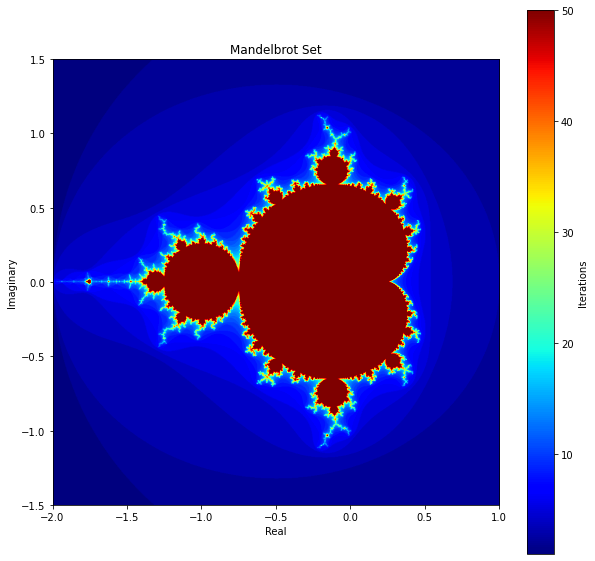

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def mandelbrot(c, max_iter):
    """
    Computes the color of a point in the Mandelbrot set.
    :param c: Complex number representing the point.
    :param max_iter: Maximum iterations to determine if the point escapes.
    :return: Iteration count when point escapes, or max_iter.
    """
    z = 0
    n = 0
    while abs(z) <= 2 and n < max_iter:
        z = z * z + c
        n += 1
    return n

def mandelbrot_set(xmin, xmax, ymin, ymax, width, height, max_iter):
    """
    Generates a Mandelbrot set image.
    :param xmin: Minimum real value.
    :param xmax: Maximum real value.
    :param ymin: Minimum imaginary value.
    :param ymax: Maximum imaginary value.
    :param width: Image width.
    :param height: Image height.
    :param max_iter: Maximum iterations.
    :return: Numpy array of the Mandelbrot image.
    """
    mandelbrot_image = np.zeros((height, width))
    for x in range(width):
        for y in range(height):
            real = xmin + x * (xmax - xmin) / (width - 1)
            imag = ymin + y * (ymax - ymin) / (height - 1)
            c = complex(real, imag)
            mandelbrot_image[y, x] = mandelbrot(c, max_iter)
    return mandelbrot_image

# Parameters for the set
xmin, xmax, ymin, ymax = -2.0, 1.0, -1.5, 1.5
width, height = 1000, 1000
max_iter = 50

# Generate and display the Mandelbrot set
mandelbrot_image = mandelbrot_set(xmin, xmax, ymin, ymax, width, height, max_iter)
plt.figure(figsize=(10, 10))
plt.imshow(mandelbrot_image, extent=(xmin, xmax, ymin, ymax), cmap='jet', origin='lower')
plt.colorbar(label='Iterations')
plt.title('Mandelbrot Set')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()

# Hardware

## System Generator

The first system generator file was created to square the complex number $z_{n}^{2}$.

Given its complex nature the equation for squaring a complex number is: 

$z^{2} = (x + yi)^{2} = x^{2} - y^{2} + 2xyi $. 

Where $x^{2} - y^{2}$ is Real and $2xyi$ is imaginary.

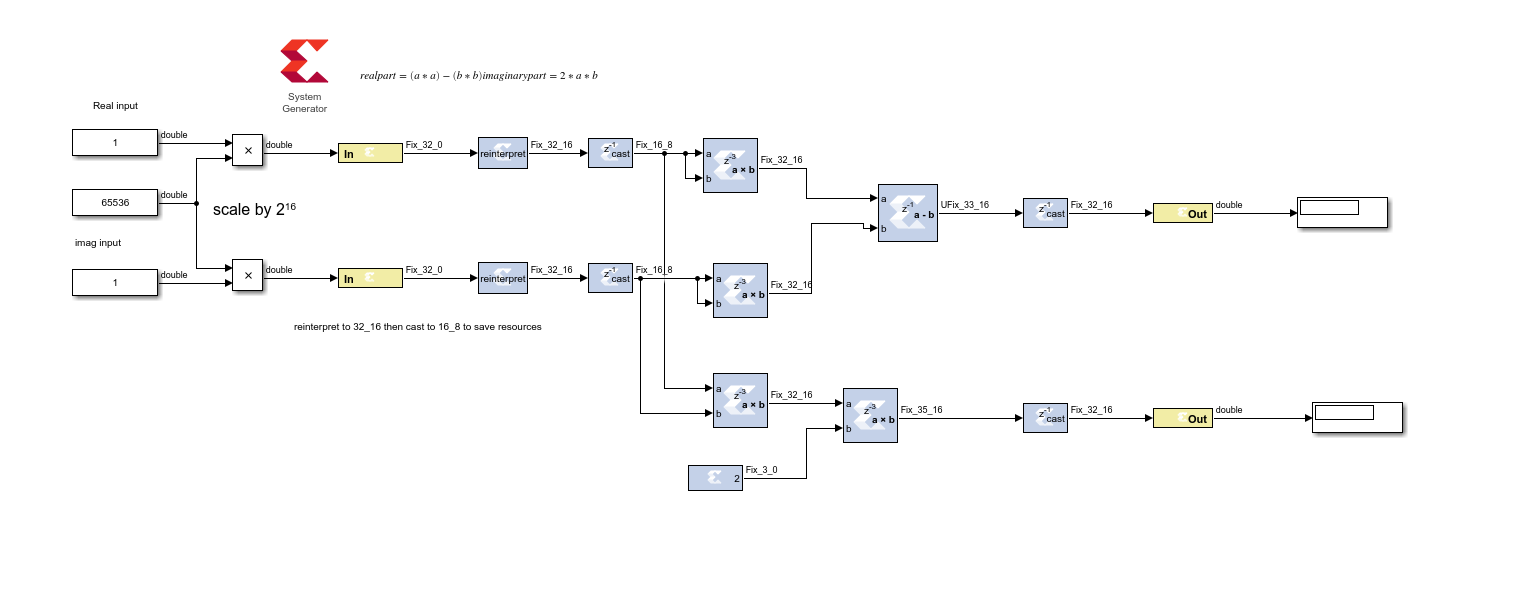
Figure 1 Mandelbrot Equation .slx File

The second system generator file was created to approximate the magnitude of $z_{n}$. Once again given as the equation is complex the magnitude of a complex number is given as: $|z|= \sqrt{x^{2}+y^{2}} $. As the square root operation is very slow a magnitude approximation method had to be created. The method chosen was the "Alpha Max plus Beta Min" algorithm which is a high speed approximation of the square root operation. The equation is:

$∣z∣ = αMax(|x|,|y|) + βMin(|x|,|y|)$.

The absolute value operations folds the complex number into the range of 0-90 degrees, and the min, max operations further fold the complex number into the range of 0-45 degrees. Within this limited range, a linear combination of I and Q are a good approximation of magnitude.

$ Min Peak Err: α = 0.960433870103 , β = 0.397824734759$

Using this to 4 decimal places gives a decent enough estimate for our purpose.

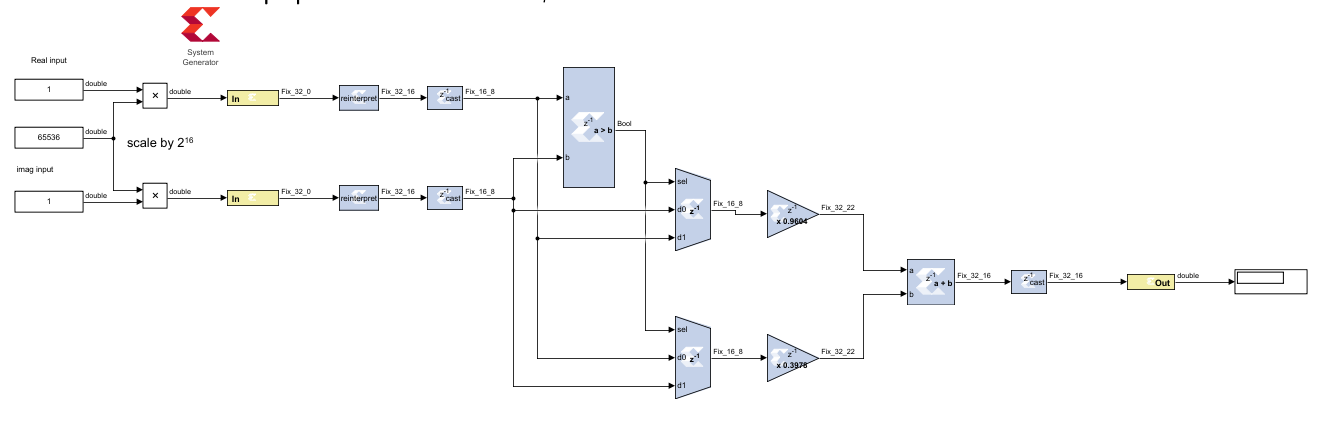
Figure 2 Magnitude Approximation .slx File

The IP cores for each of these models were generated and taken over to Vivado.

## Vivado

Following similar routine to the tutorials a block diagram was created in vivado and the IP cores were added.

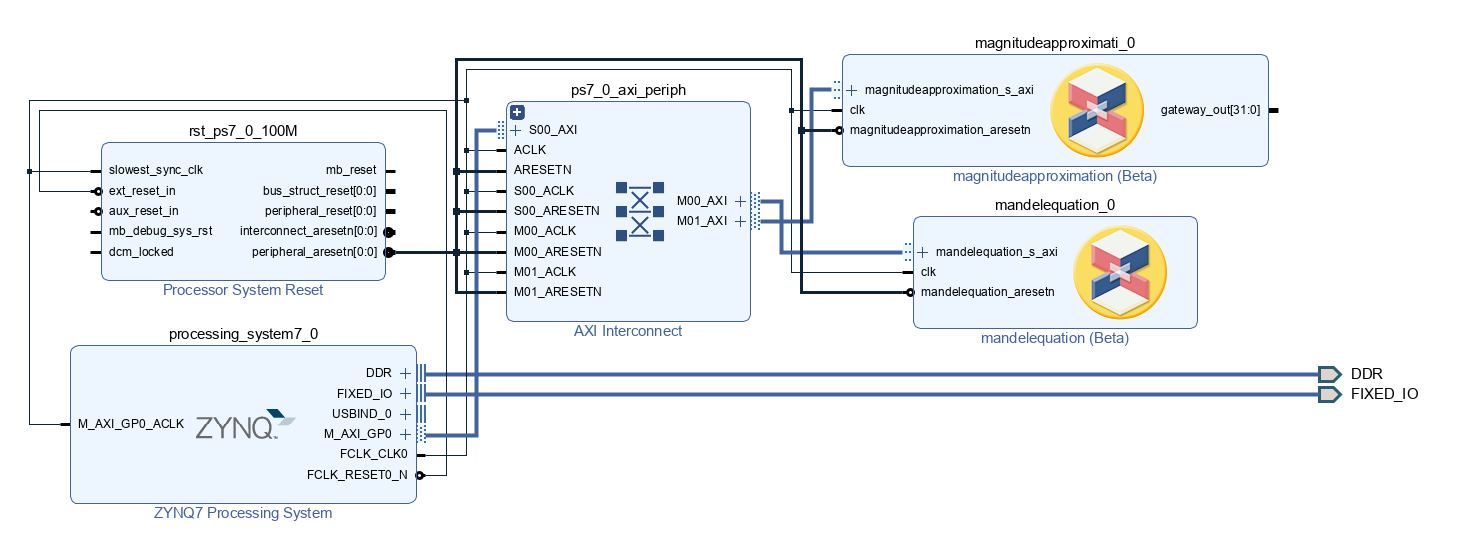
Figure 3 Entire Block Diagram in Vivado

A wrapper was then created and a bitstream file (.bit) and hardware hand-off  file (.hwh) was exported and stored on the PYNQ chip.

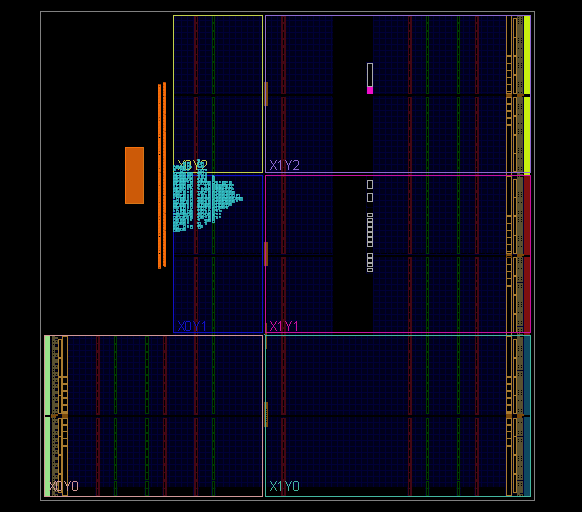 
Figure 4 The implemented design

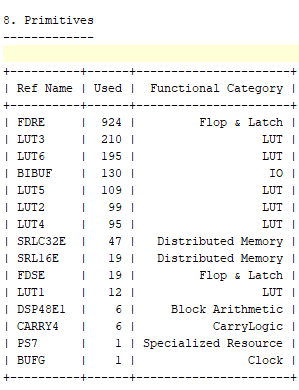
Figure 5 Board utilisation

## Python Code

Firstly the required libraries were imported aswell as the overlay on the PYNQ chip. 

In [2]:
from pynq import Overlay
import matplotlib.pyplot as plt
import numpy
from ipywidgets import *

In [3]:
ol = Overlay("design_1_wrapper.bit")
ol?


Can see the cores under the IP core section

In [4]:
mandel = ol.mandelequation_0#Mandel IP Core
mag = ol.magnitudeapproximati_0#Magnitude IP Core

Functions were created for the following:

    1. Converson from binary output from PYNQ chip to a signed integer
    2. A function for the Mandelbrot Squaring
    3. A function for the Magnitude Approximation

In [5]:
    """
    Converts a binary output from the PYNQ chip to a signed integer.
    param val: Binary value.
    param b: Bit width.
    return: Signed integer.
    """
def to_signed(val,b):
        signedVal = val-(2**b)*int(str((val)>>b-1)) #binary to signed integer
        return signedVal

    """
    Squares a complex number using the Mandel IP core.
    param z: Complex number.
    return: Squared complex number.
    """
def square(z):
        mandel.write(0x00, int((z.real*2**(16)))) #real input
        mandel.write(0x04, int((z.imag*2**(16)))) #imaginary input
        re = to_signed(mandel.read(0x0C),32)*2**(-16)#scale back down
        im = to_signed(mandel.read(0x08),32)*2**(-16)#scale back down
        sq = complex(re,im) #output
        return sq #x + yi output

    """
    Approximates the magnitude of a complex number using the Magnitude IP core.
    param z: Complex number.
    return: Approximated magnitude.
    """
def magnitude(z):
        mag.write(0x00, abs(int((z.real*2**(16))))) #real input
        mag.write(0x04, abs(int((z.imag*2**(16)))))#imaginary input
        magnitude = ((mag.read(0x08))*2**(-16))#scale back down
        return magnitude

Then a function for the mandelbrot set which checks if the magnitude is greater than two for each iteration. We know if the magnitude is greater than 2 then the mandolbrot will tend to infinity. Some more clarification follows:

First assume that $|c|≤2$. Let $ f(z)=z^{2}+c$ and assume that $|z_{n}|=2+a$, where $a>0$.

Then $|z_{n+1}|=|f(z_{n})|=|z_{n}^{2}+c|≥|z_{n}|2−|c|≥|z_{n}|2−2=(2+a)^{2}−2=2+2a+a^{2}>2+2a$

By induction $|z_{n+k}|>2+ak→∞$ as $k→∞$, so zn escapes to infinity.

If $|c|>2$, a similar analysis shows that $zn→∞$ so we don't even have to consider such values of $c$.

In [6]:
 """
    Computes the Mandelbrot set using hardware acceleration.
    :param Re: Real part of the complex number.
    :param Im: Imaginary part of the complex number.
    :param max_iter: Maximum iterations.
    :return: Iteration count.
    """
def mandelbrotPL(Re,Im,max_iter):
    c = complex(Re,Im) # is a constant 
    z = complex(0,0)
    for i in range(max_iter):
        z = square(z) + c
        if (magnitude(z) > 2):
            return i
    return max_iter

Finally a plot was created to plot the mandelbrot set including a widget that lets you set the max iterations, this variable can be changed by altering the $max$ variable in the code.

In [43]:
def updatePL(Iterations):
    cols = 200
    rows = 200
    result = numpy.zeros([rows,cols])
    for row_index, Re in enumerate(numpy.linspace(-2,2,num=rows)):
        for col_index, Im in enumerate(numpy.linspace(-2,2,num=cols)):
            result[col_index,row_index] = mandelbrotPL(Re,Im,Iterations)
    plt.figure(dpi=150)
    plt.imshow(result.T,cmap="jet",extent=[-2,2,-2,2])
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.show()

ite = widgets.IntSlider(min=5,max=50,step=1,value=25)
interact_manual(updatePL, Iterations=ite);

interactive(children=(IntSlider(value=25, description='Iterations', max=50, min=5), Button(description='Run In…

The software version takes around 1 min to compute 50 iterations of the mandelbrot. Where as the hardware variation takes around 1 min and 55 seconds to compute 50 iterations. The hardware variation could be improved by further paraellisiing the design or implementing an AXI stream core or AXI Memory-Mapped.

## References and Reading

https://en.wikipedia.org/wiki/Mandelbrot_set
https://mathworld.wolfram.com/MandelbrotSet.html
https://www.codingame.com/playgrounds/2358/how-to-plot-the-mandelbrot-set/mandelbrot-set
https://dspguru.com/dsp/tricks/magnitude-estimator/
https://en.wikipedia.org/wiki/Alpha_max_plus_beta_min_algorithm
https://realpython.com/mandelbrot-set-python/

